## Stock Price Prediction with Sentiment Analysis

In [1]:
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
import os

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print(f"Directory '{cfg.OUTPUT_DIR}' is ready.")

Directory 'Output' is ready.


### Load and Analyze News Data

In [4]:
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(sentiment_csv_path, index_col='Date', parse_dates=True)

print("Sentiment data ready.")

Loading existing sentiment data from Dataset/NVDA_daily_sentiment.csv...
Sentiment data ready.


### Fetch Stock Data and Calculate Technical Indicators

In [5]:
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)
stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
tech_data = dp.calculate_technical_indicators(stock_data)

\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.


### Prepare data for technical models

In [6]:
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = mdl.prepare_data_for_lstm(
    tech_data, cfg.BASELINE_FEATURES, cfg.BASELINE_TARGET, cfg.SEQUENCE_LENGTH, cfg.TEST_SIZE
)

### Prepare Data for Single Layer LSTM Model

In [7]:
print("\\n--- Running LSTM Model (Single-Layer) ---")
baseline_model = mdl.build_single_layer_lstm((X_train_tech.shape[1], X_train_tech.shape[2]))
baseline_model.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
baseline_history = baseline_model.fit(
    X_train_tech, y_train_tech, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running LSTM Model (Single-Layer) ---


2025-07-25 15:03:11.999485: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-25 15:03:11.999512: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-25 15:03:11.999518: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753452191.999532  160274 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753452191.999548  160274 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,249 (270.50 KB)

 Trainable params: 69,249 (270.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-07-25 15:03:12.365778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0173 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0042 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0039 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0034 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 8/10
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 9/

#### Evaluate Baseline Model

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Plot saved to Output/NVDA_LSTM_Single-Layer_analysis.png


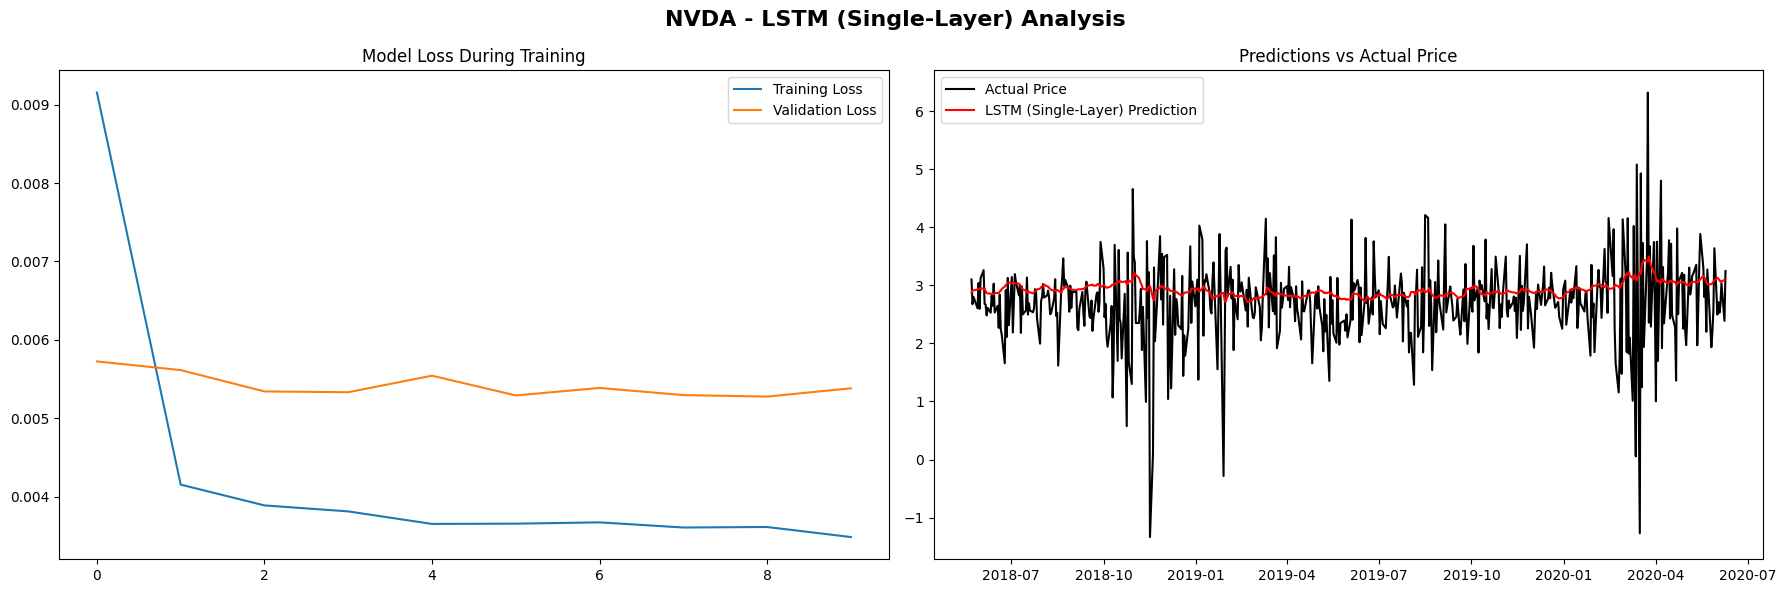

In [8]:
base_preds = baseline_model.predict(X_test_tech)
close_scaler = MinMaxScaler().fit(tech_data[['Close']])
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(base_preds)
baseline_metrics = ut.calculate_metrics(y_test_tech_scaled, base_preds_scaled, 'LSTM (Single-Layer)')
test_dates_tech = tech_data.index[-len(y_test_tech_scaled):]
ut.plot_model_results(baseline_history, y_test_tech_scaled, base_preds_scaled, test_dates_tech, cfg.STOCK_SYMBOL,
                      'LSTM (Single-Layer)')

### Multi-Layer LSTM Model

In [9]:
print("\\n--- Running Multi-Layer Model ---")
multi_layer_model = mdl.build_multi_layer_lstm((X_train_tech.shape[1], X_train_tech.shape[2]))
multi_layer_model.summary()
multi_layer_history = multi_layer_model.fit(
    X_train_tech, y_train_tech, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running Multi-Layer Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,179 (469.45 KB)

 Trainable params: 120,179 (469.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0194 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0038 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0036 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0034 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0035 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0033 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 8/10
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0034
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034 - val_loss: 0.0052 - learning_rate: 0.00

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Plot saved to Output/NVDA_Multi-Layer_LSTM_analysis.png


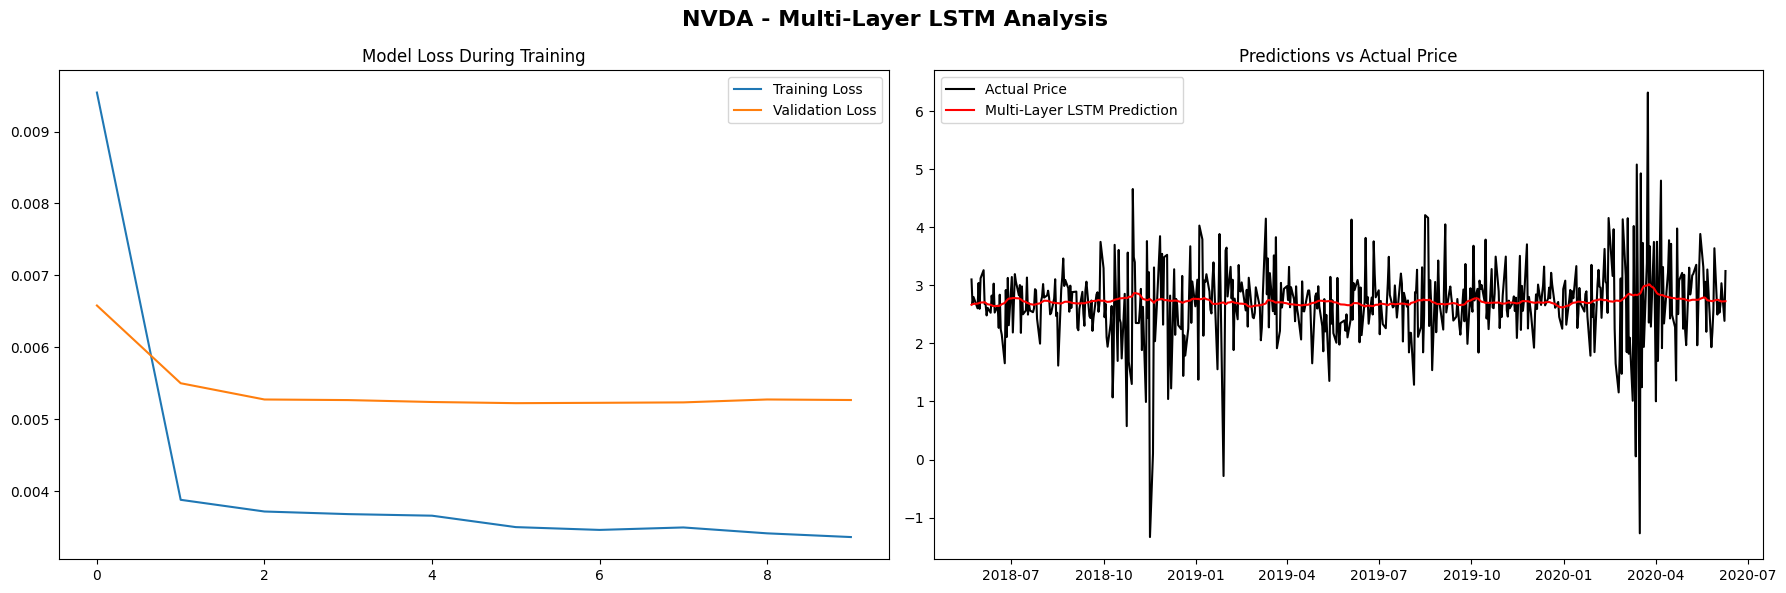

In [10]:
multi_preds = multi_layer_model.predict(X_test_tech)
multi_preds_scaled = close_scaler.inverse_transform(multi_preds)
multi_layer_metrics = ut.calculate_metrics(y_test_tech_scaled, multi_preds_scaled, 'Multi-Layer LSTM')
ut.plot_model_results(multi_layer_history, y_test_tech_scaled, multi_preds_scaled, test_dates_tech, cfg.STOCK_SYMBOL, 'Multi-Layer LSTM')

### Sentiment-Enhanced LSTM Model (Single-Layer)

In [11]:
print("\\n--- Running Sentiment-Enhanced Model ---")
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = mdl.prepare_data_for_lstm(
    enhanced_full_data, cfg.ENHANCED_FEATURES, cfg.ENHANCED_TARGET, cfg.SEQUENCE_LENGTH, cfg.TEST_SIZE
)

enhanced_model = mdl.build_single_layer_lstm((X_train_enh.shape[1], X_train_enh.shape[2]))
enhanced_model.summary()

enhanced_history = enhanced_model.fit(
    X_train_enh, y_train_enh, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running Sentiment-Enhanced Model ---
\n🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2573, 16)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,785 (276.50 KB)

 Trainable params: 70,785 (276.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0131 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0041 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0039 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0038 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 8/10
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0036
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036 - val_loss: 0.0053 - learning_rate: 0.00

#### Evaluate Sentiment-Enhanced Model

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Plot saved to Output/NVDA_Enhanced_LSTM_analysis.png


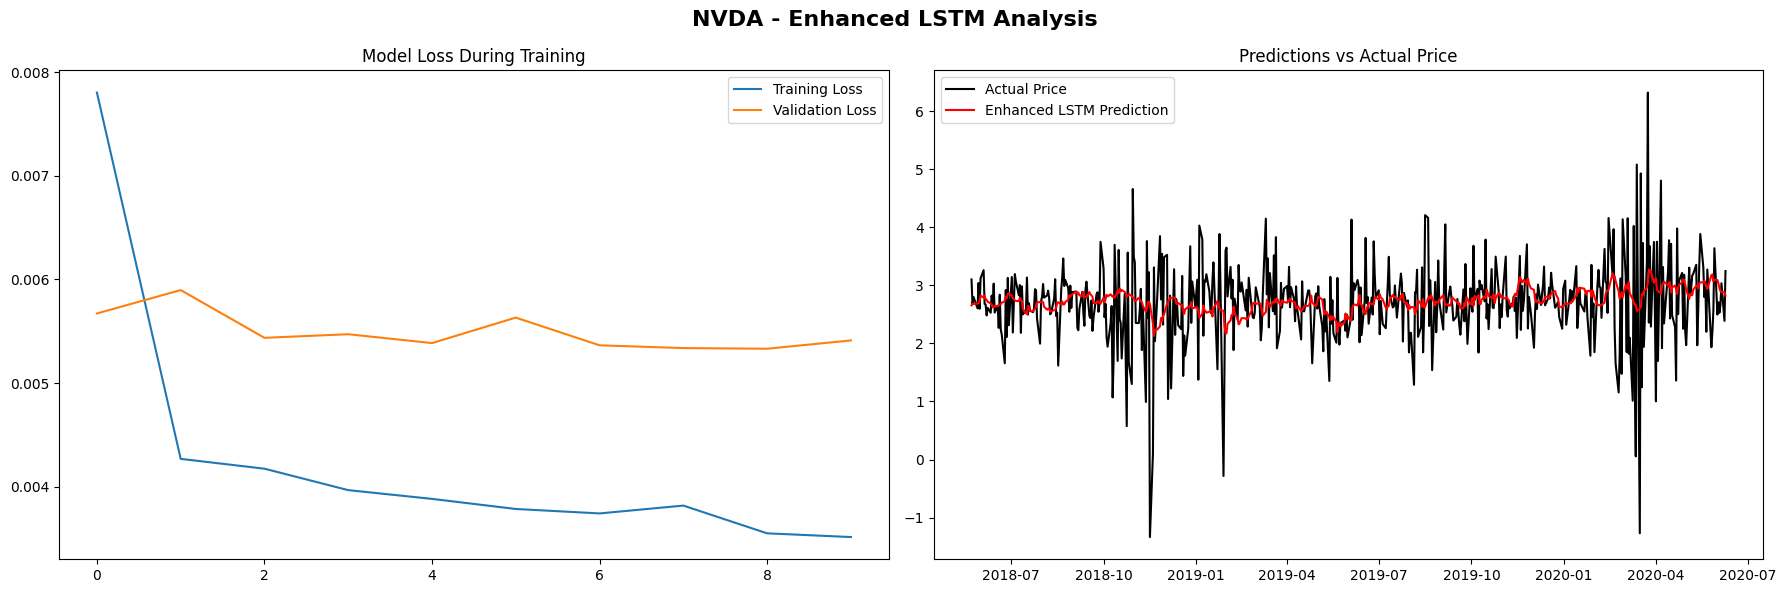

In [12]:
enh_preds = enhanced_model.predict(X_test_enh)
y_test_enh_scaled = close_scaler.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler.inverse_transform(enh_preds)
enhanced_metrics = ut.calculate_metrics(y_test_enh_scaled, enh_preds_scaled, 'Enhanced LSTM')
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled):]
ut.plot_model_results(enhanced_history, y_test_enh_scaled, enh_preds_scaled, test_dates_enh, cfg.STOCK_SYMBOL, 'Enhanced LSTM')

### Sentiment-Enhanced LSTM Model (Multi-Layer)

In [13]:
print("\\n--- Running Multi-Layer Enhanced Model ---")
multi_enhanced_model = mdl.build_multi_layer_lstm((X_train_enh.shape[1], X_train_enh.shape[2]))
multi_enhanced_history = multi_enhanced_model.fit(
    X_train_enh, y_train_enh, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running Multi-Layer Enhanced Model ---
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0200 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0038 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0035 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0036 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0035 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 8/10
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0033
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Plot saved to Output/NVDA_Multi-Layer_Enhanced_LSTM_analysis.png


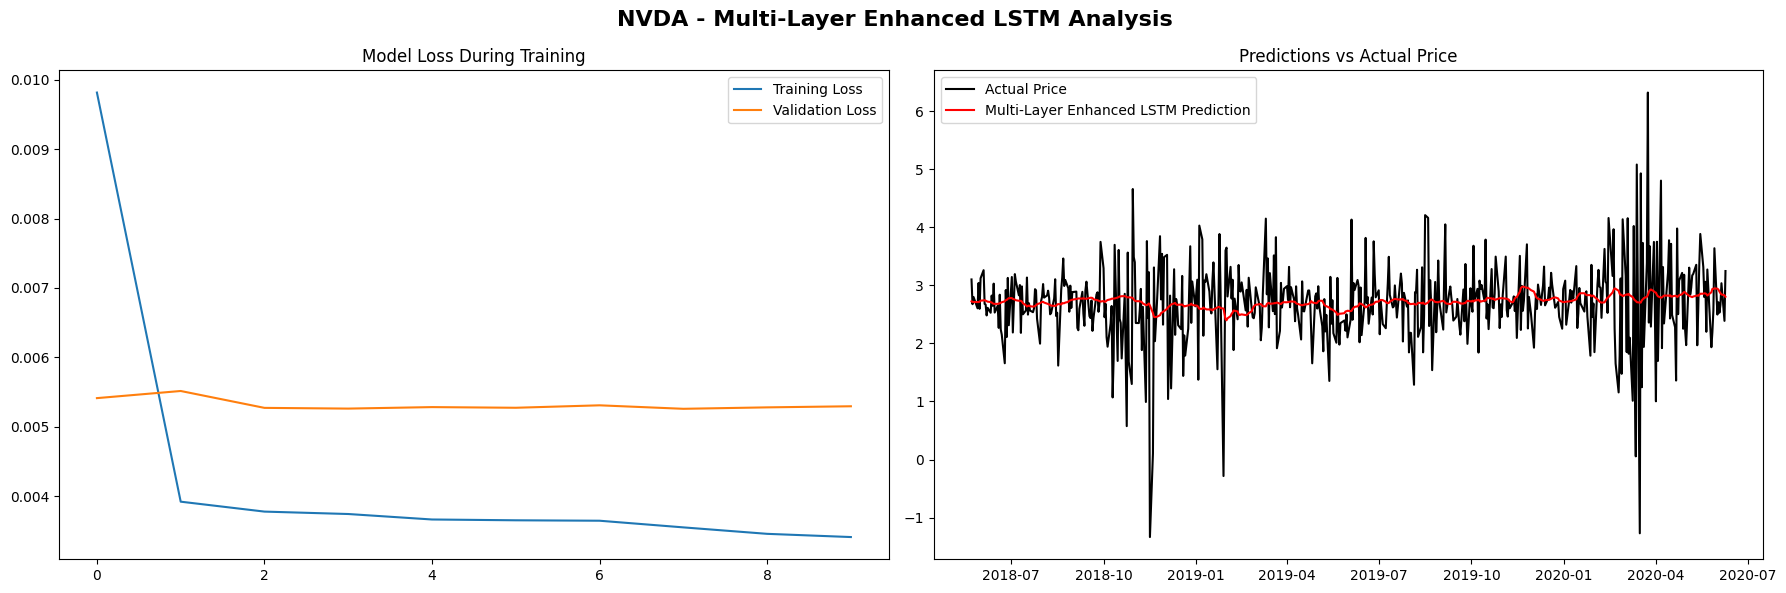

In [14]:
multi_enh_preds = multi_enhanced_model.predict(X_test_enh)
multi_enh_preds_scaled = close_scaler.inverse_transform(multi_enh_preds)
multi_enhanced_metrics = ut.calculate_metrics(y_test_enh_scaled, multi_enh_preds_scaled, 'Multi-Layer Enhanced LSTM')
ut.plot_model_results(multi_enhanced_history, y_test_enh_scaled, multi_enh_preds_scaled, test_dates_enh, cfg.STOCK_SYMBOL, 'Multi-Layer Enhanced LSTM')


### Final Performance Comparison

In [15]:
naive_preds = np.roll(y_test_tech_scaled, 1)
naive_preds[0] = y_test_tech_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_tech_scaled, naive_preds, 'Naive Baseline')

# Performance DataFrame
all_metrics_df = pd.DataFrame([
    baseline_metrics,
    multi_layer_metrics,
    enhanced_metrics,
    multi_enhanced_metrics,
    naive_metrics
]).round(4)

print("\\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))

\n📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
                    Model   RMSE    MAE  Directional_Accuracy
      LSTM (Single-Layer) 0.7534 0.5189               41.0506
         Multi-Layer LSTM 0.7086 0.4868               45.9144
            Enhanced LSTM 0.7321 0.5127               36.1868
Multi-Layer Enhanced LSTM 0.7150 0.4974               42.2179
           Naive Baseline 1.0739 0.7357               30.1556


### Plot Results

Plot saved to Output/NVDA_all_models_comparison.png


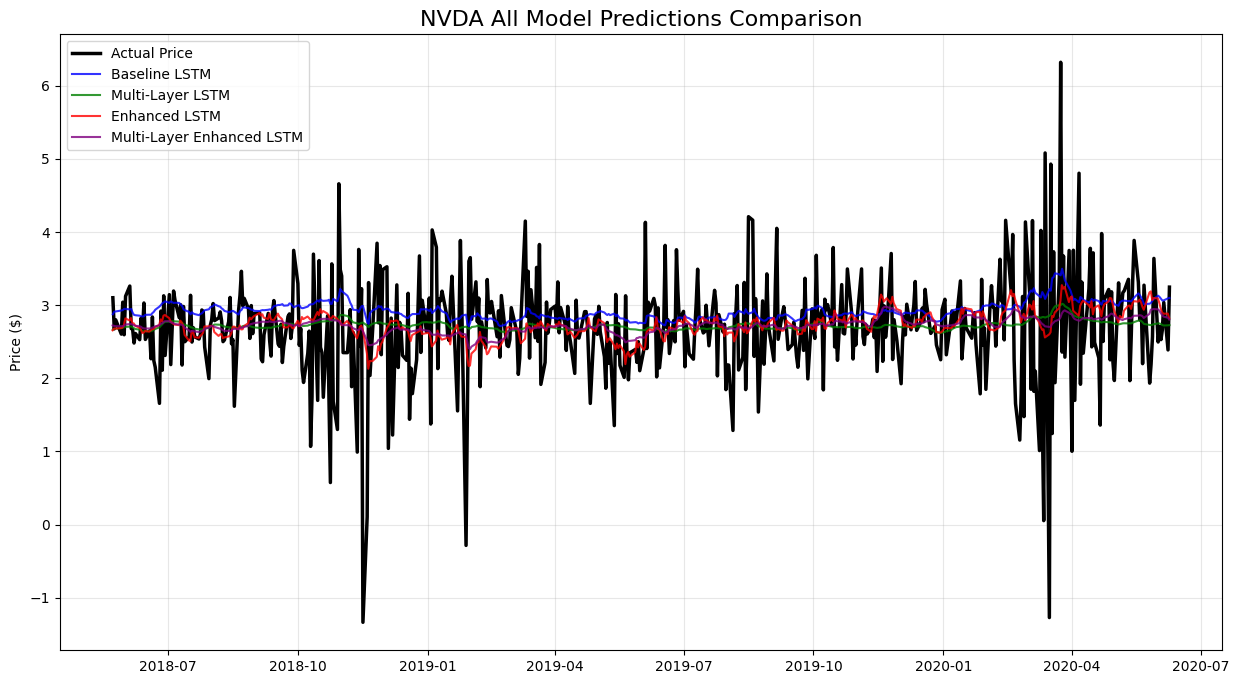

In [16]:
plot_data = {
    'Actual': {'dates': test_dates_tech, 'values': y_test_tech_scaled},
    'Baseline LSTM': {'dates': test_dates_tech, 'values': base_preds_scaled},
    'Multi-Layer LSTM': {'dates': test_dates_tech, 'values': multi_preds_scaled},
    'Enhanced LSTM': {'dates': test_dates_enh, 'values': enh_preds_scaled},
    'Multi-Layer Enhanced LSTM': {'dates': test_dates_enh, 'values': multi_enh_preds_scaled}
}
ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL)